In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Train set

In [15]:
%%time
dir = Path('C:\\Users\\ASUS\\OneDrive\\Desktop\\Thisis\\ECG_Image_data\\train')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

Wall time: 1.8 s


,Filepath,Label
0,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
1,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
2,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
3,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
4,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
...,...,...
99194,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,V
99195,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,V
99196,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,V
99197,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,V


In [16]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [17]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

N    640
Q    640
S    640
F    640
M    640
V    640
Name: Label, dtype: int64

# Test set

In [18]:
%%time
dir = Path('C:\\Users\\ASUS\\OneDrive\\Desktop\\Thisis\\ECG_Image_data\\test')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

Wall time: 375 ms


,Filepath,Label
0,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
1,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
2,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
3,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
4,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,F
...,...,...
24794,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,V
24795,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,V
24796,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,V
24797,C:\Users\ASUS\OneDrive\Desktop\Thisis\ECG_Imag...,V


In [19]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [20]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

M    160
F    160
Q    160
N    160
V    160
S    160
Name: Label, dtype: int64

# Image generators

In [21]:
def gray_torgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.merge((image,image,image))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [22]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255,
    validation_split=0.2
  
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255
)

In [23]:
size=224
color_mode='rgb'
batch_size=32

train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.
Found 960 validated image filenames belonging to 6 classes.


In [24]:
test_images.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

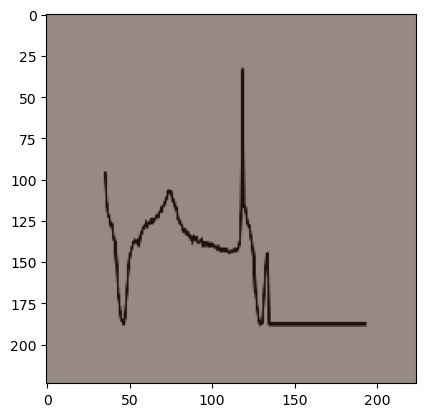

In [25]:
plt.imshow(test_images[0][0][3])

# Modeling

# CNN

In [28]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [36]:
num_classes = 6

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 394272)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                25233472  
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 25,234,758
Trainable params: 25,234,758
Non-trainable params: 0
__________________________________________

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
history = model.fit(train_images, validation_data=val_images, epochs=10)

Epoch 1/10
96/96 [==============================] - 87s 902ms/step - loss: 2.4580 - accuracy: 0.4329 - val_loss: 1.0102 - val_accuracy: 0.5078
Epoch 2/10
96/96 [==============================] - 78s 814ms/step - loss: 0.7506 - accuracy: 0.7080 - val_loss: 0.7486 - val_accuracy: 0.7826
Epoch 3/10
96/96 [==============================] - 80s 827ms/step - loss: 0.5025 - accuracy: 0.7926 - val_loss: 0.5840 - val_accuracy: 0.7266
Epoch 4/10
96/96 [==============================] - 78s 815ms/step - loss: 0.3712 - accuracy: 0.8141 - val_loss: 0.5306 - val_accuracy: 0.7956
Epoch 5/10
96/96 [==============================] - 79s 818ms/step - loss: 0.2563 - accuracy: 0.9118 - val_loss: 0.4406 - val_accuracy: 0.8854
Epoch 6/10
96/96 [==============================] - 77s 803ms/step - loss: 0.1456 - accuracy: 0.9570 - val_loss: 0.4024 - val_accuracy: 0.8932
Epoch 7/10
96/96 [==============================] - 77s 807ms/step - loss: 0.0885 - accuracy: 0.9697 - val_loss: 0.3863 - val_accuracy: 0.8945

In [40]:
test_loss, test_accuracy = model.evaluate(test_images)

30/30 [==============================] - 9s 305ms/step - loss: 0.5143 - accuracy: 0.9240


In [55]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [56]:
model.compile(loss='categorical_crossentropy',optimizer='adam',
            metrics=['accuracy',
                     'Precision',
                     'Recall',
                     tf.keras.metrics.AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False
                                    )])

In [58]:
%%time
result=model.fit(
    train_images,
    steps_per_epoch=3072//32,
    validation_data=val_images,
    validation_steps=768//32,
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9886 - precision: 0.9896 - recall: 0.9880 - auc_4: 0.9994
Epoch 1: val_accuracy improved from -inf to 0.93359, saving model to best_model.h5
96/96 [==============================] - 84s 871ms/step - loss: 0.0451 - accuracy: 0.9886 - precision: 0.9896 - recall: 0.9880 - auc_4: 0.9994 - val_loss: 0.4455 - val_accuracy: 0.9336 - val_precision: 0.9360 - val_recall: 0.9336 - val_auc_4: 0.9848
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9990 - recall: 0.9987 - auc_4: 1.0000
Epoch 2: val_accuracy did not improve from 0.93359
96/96 [==============================] - 77s 797ms/step - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9990 - recall: 0.9987 - auc_4: 1.0000 - val_loss: 0.4570 - val_accuracy: 0.9323 - val_precision: 0.9335 - val_recall: 0.9323 - val_auc_4: 0.9851
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.01

In [60]:
from keras.models import load_model
best_model=load_model('best_model.h5')
results = best_model.evaluate(test_images, verbose=0)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.4f}%".format(results[1] * 100))
print("Test Precision: {:.4f}%".format(results[2] * 100))
print("   Test Recall: {:.4f}%".format(results[3] * 100))
print("      Test AUC: {:.4f}".format(results[4] ))

     Test Loss: 0.6239
 Test Accuracy: 93.4375%
Test Precision: 93.4375%
   Test Recall: 93.4375%
      Test AUC: 0.9793


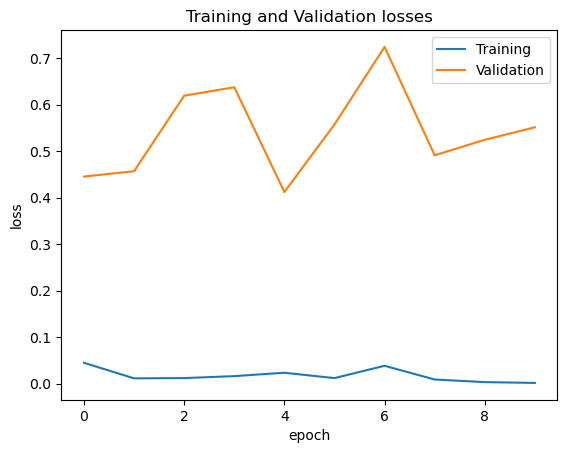

In [61]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

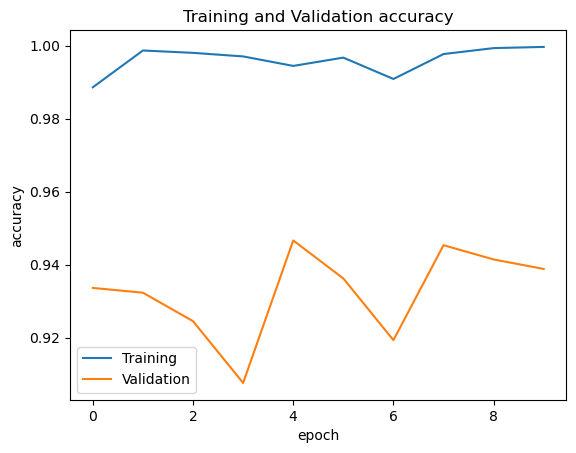

In [62]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig( 'accuracy.jpg', dpi=500, bbox_inches = 'tight')

In [63]:
y_pred = best_model.predict(test_images)
y_pred

30/30 [==============================] - 5s 164ms/step


array([[0.00000000e+00, 9.99999642e-01, 0.00000000e+00, 0.00000000e+00,
        3.59567480e-07, 0.00000000e+00],
       [9.97808874e-01, 1.69980518e-15, 1.75203962e-09, 2.19112798e-03,
        4.65385739e-08, 2.51600337e-16],
       [3.36994344e-05, 8.89984201e-17, 4.07218747e-03, 9.95891809e-01,
        2.26417478e-06, 5.40518630e-10],
       ...,
       [9.95200992e-01, 1.04393396e-13, 2.00064481e-08, 4.79858182e-03,
        3.67166734e-07, 2.03511541e-14],
       [0.00000000e+00, 9.99989867e-01, 2.59981617e-32, 0.00000000e+00,
        1.01257028e-05, 0.00000000e+00],
       [5.57868747e-13, 1.24566052e-15, 9.96637702e-01, 3.03325173e-03,
        3.49524555e-07, 3.28655093e-04]], dtype=float32)

In [1]:
import matplotlib.pyplot as plt
import cv2

In [2]:
image = cv2.imread('C:\\Users\\ASUS\\OneDrive\\Desktop\\Thisis\\ECG_Image_data\\train')

In [4]:
if image is not None:
    # Preprocess the image if needed

    # Display the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: Hide the axis
    plt.show()
else:
    print("Error loading the image. Please check the file path and format.")

Error loading the image. Please check the file path and format.
